In [71]:
%load_ext autoreload
import glob
import shutil
import nibabel
import pandas as pd
import numpy as np
import os
from IPython.core.debugger import set_trace
from datetime import datetime
from collections import defaultdict, Counter
from matplotlib import pyplot as plt
from tqdm import notebook, tqdm
from joblib import Parallel, delayed
from tensorboardX import SummaryWriter  

import torchio as tio
import torchvision
import torch
from torch import nn
from torch import autograd
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import yaml
from easydict import EasyDict as edict

from utils import get_capacity, create_dicts, normalize, load, video, video_comparison, save, DiceScoreBinary
from datasets import BrainMaskDataset

from multiprocessing import cpu_count
N_CPU = cpu_count()

from sklearn.metrics import silhouette_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split

from IPython.core.display import display, HTML
from celluloid import Camera
from itertools import product

SEED = 42
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
!nvidia-smi

Wed Jan 19 00:21:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 460.27.04    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX TIT...  Off  | 00000000:02:00.0  On |                  N/A |
| 22%   52C    P5    36W / 250W |     17MiB / 12211MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX TIT...  Off  | 00000000:03:00.0 Off |                  N/A |
| 22%   

In [3]:
labels_components = np.load('label_info_v2.npy', allow_pickle=True).item()
single_component_keys = {k for k,v in labels_components.items() if len(v['cc3d'][0]) != 2}

labels_broken = {'43','n27','33','37', '9', 'n31',
                 'n30', 'n10', 'n8', '47', '6',
                 '25', '12'}.union(single_component_keys)

In [4]:
root = '/nfs/garfield/ibulygin/preprocessed_data_v2'
root_label = os.path.join(root, 'label')


feature_paths_templates = {
      'label':os.path.join(root, 'label/{label}.nii'),
      'mask':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_desc-brain_mask.nii.gz'),
      'curv':os.path.join(root, 'curv/norm-{label}.nii'),
      'sulc':os.path.join(root, 'sulc/norm-{label}.nii'),
      'thickness':os.path.join(root, 'thickness/norm-{label}.nii'),
      'bT1':os.path.join(root, 'bluring-T1/sub-{label}_T1blurring-in-volume.nii.gz'),
      'bT2':os.path.join(root, 'bluring-T2/sub-{label}_T2blurring-in-volume.nii.gz'),
      'T1w':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'),
      'T2':os.path.join(root, 'T2/{label}.nii'),
      'CSF':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_label-CSF_probseg.nii.gz'),
      'GM':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_label-GM_probseg.nii.gz'),
      'WM':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_label-WM_probseg.nii.gz'),
        }

paths_dict = create_dicts(root_label,
                         feature_paths_templates, 
                         broken_labels=labels_broken)

No curv for 51
No curv for 53
No curv for n20
No bT1 for 27
No curv for 57
No curv for G015
No curv for n25
No curv for n23
No curv for 52
No curv for 58
No curv for 59
No curv for 50


In [5]:
len(paths_dict)

63

In [6]:
def calculate_sym_patches(k, paths_dict, labels_components, AUGMENTATION_STEPS, PATCH_SIZE, fcd_threshold):
    
    patches = []
    path_dict = paths_dict[k]
    label_info = labels_components[k]
    center = label_info['center']

    aug_iter = np.arange(-AUGMENTATION_STEPS, AUGMENTATION_STEPS+1)
    for shift in list(product(aug_iter, aug_iter, aug_iter)):
        
        label = nibabel.load(path_dict['label']).get_fdata()
        n_fcd = label.sum()
        
        center_i = center + np.array(shift)
        
        X,Y,Z = label.shape
        x,y,z = center_i
        
        x1_fcd, x2_fcd = x-PATCH_SIZE, x+PATCH_SIZE 
        x1,x2, = X-x-PATCH_SIZE, X-x+PATCH_SIZE 
        y1,y2 = y-PATCH_SIZE,y+PATCH_SIZE
        z1,z2 = z-PATCH_SIZE,z+PATCH_SIZE
        
        patch_fcd = label[x1_fcd:x2_fcd,y1:y2,z1:z2]
        patch_nonfcd = label[x1:x2,y1:y2,z1:z2]
        
        if (patch_nonfcd.sum() < 0.01*n_fcd) and patch_fcd.sum()/n_fcd >= fcd_threshold:
            
            info_patch_fcd = {}
            info_patch_fcd['patch_center'] = center_i
            info_patch_fcd['label'] = k
            info_patch_fcd['is_fcd'] = 1
            
            info_patch_nonfcd = {}
            info_patch_nonfcd['patch_center'] = np.array([X-x,y,z])
            info_patch_nonfcd['label'] = k
            info_patch_nonfcd['is_fcd'] = 0

            patches.append(info_patch_fcd)
            patches.append(info_patch_nonfcd)
    
        else:
            print(f'Skip patch with offset {shift} for label: {k}')
            
    return patches

In [7]:
with open('./configs/sym_classification.yaml') as f:
    config = edict(yaml.safe_load(f))
    
AUGMENTATION_STEPS = config.dataset.augmentation_steps
PATCH_SIZE = config.dataset.patch_size
fcd_threshold = config.dataset.fcd_threshold

In [8]:
patches = Parallel(n_jobs=N_CPU//2)(delayed(calculate_sym_patches)(k, 
                                              paths_dict, 
                                              labels_components, 
                                              AUGMENTATION_STEPS, 
                                              PATCH_SIZE,
                                              fcd_threshold) for k in tqdm(paths_dict.keys()))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [01:19<00:00,  1.26s/it]


Skip patch with offset (-2, -2, -2) for label: 19
Skip patch with offset (-2, -2, -1) for label: 19
Skip patch with offset (-2, -2, 0) for label: 19
Skip patch with offset (-2, -2, 1) for label: 19
Skip patch with offset (-2, -2, 2) for label: 19
Skip patch with offset (-2, -1, -2) for label: 19
Skip patch with offset (-2, -1, -1) for label: 19
Skip patch with offset (-2, -1, 0) for label: 19
Skip patch with offset (-2, -1, 1) for label: 19
Skip patch with offset (-2, -1, 2) for label: 19
Skip patch with offset (-2, 0, -2) for label: 19
Skip patch with offset (-2, 0, -1) for label: 19
Skip patch with offset (-2, 0, 0) for label: 19
Skip patch with offset (-2, 0, 1) for label: 19
Skip patch with offset (-2, 0, 2) for label: 19
Skip patch with offset (-2, 1, -2) for label: 19
Skip patch with offset (-2, 1, -1) for label: 19
Skip patch with offset (-2, 1, 0) for label: 19
Skip patch with offset (-2, 1, 1) for label: 19
Skip patch with offset (-2, 1, 2) for label: 19
Skip patch with offset

In [9]:
patches_all = []
for p in patches:
    patches_all += p

In [10]:
df = pd.DataFrame(patches_all)

In [11]:
df.shape

(14250, 3)

In [12]:
# df.to_csv('sym_patches', index=None)

In [13]:
metadata_path = '/nfs/garfield/ibulygin/metadata_v2'
metadata = np.load(f'{metadata_path}.npy',allow_pickle=True).item()

In [14]:
val_labels = set(metadata['test']).intersection(set(df.label.unique()))

In [15]:
len(metadata['test']), len(val_labels)

(7, 7)

In [41]:
sorted(metadata['test']) == sorted(val_labels)

True

In [16]:
train_labels = list(set(df.label.unique()) - val_labels)
val_labels = list(val_labels)

In [17]:
df_train = df.loc[df['label'].isin(train_labels)]
df_val = df.loc[df['label'].isin(val_labels)]

In [18]:
df_train.shape, df_val.shape

((12500, 3), (1750, 3))

In [19]:
len(df_train.label.unique())

50

In [20]:
df_train

,patch_center,label,is_fcd
0,"[180, 192, 97]",20,1
1,"[61, 192, 97]",20,0
2,"[180, 192, 98]",20,1
3,"[61, 192, 98]",20,0
4,"[180, 192, 99]",20,1
...,...,...,...
13995,"[77, 227, 116]",35,0
13996,"[164, 227, 117]",35,1
13997,"[77, 227, 117]",35,0
13998,"[164, 227, 118]",35,1


# Visualize

In [21]:
# root = '/nfs/garfield/ibulygin/tensors_v2'
# patches_sample = []
# labels_sample = []

# for label in tqdm(val_labels):
#     x,y,z = df.query(f"label=='{label}' and is_fcd==0").iloc[0].patch_center
#     pd = PATCH_SIZE//2
#     x1,x2 = x-pd,x+pd 
#     y1,y2 = y-pd,y+pd
#     z1,z2 = z-pd,z+pd
    
#     tensor_path = os.path.join(root, f'tensor_{label}')
#     tensor_dict = torch.load(tensor_path)
#     label_tensor_torch = tensor_dict['label']

#     features = set(tensor_dict.keys()) - {'label', 'mask'}
#     brain_tensor_torch = torch.stack([tensor_dict[f] for f in features], dim=0)

#     patch = brain_tensor_torch[:,x1:x2,y1:y2,z1:z2].numpy()
#     label_patch = label_tensor_torch[x1:x2,y1:y2,z1:z2].numpy()
#     patches_sample.append(patch)
#     labels_sample.append(label_patch)    

In [22]:
# plt.ioff()
# camera = video_comparison(brain_tensor_torch.numpy(),
#                           n_slides=132)
# animation = camera.animate() # animation ready
# HTML(animation.to_html5_video()) # displaying the animation

In [23]:
# plt.ioff()
# camera = video_comparison([p[9] for p in patches_sample],
#                           labels_sample,
#                           n_slides=PATCH_SIZE-2)
# animation = camera.animate() # animation ready
# HTML(animation.to_html5_video()) # displaying the animation

# Train

In [24]:
class PatchesDataset(Dataset):

    def __init__(self, root, df, config, train=True):
        
        self.root = root
        self.train = train
        self.df = df
        self.features = config.dataset.features
        self.patch_size = config.dataset.patch_size

    def __getitem__(self, idx):

        info = self.df.iloc[idx]
        label = info.label
        x,y,z = info.patch_center
        target = torch.tensor([info.is_fcd])
        
        tensor_path = os.path.join(self.root, f'tensor_{label}')
        tensor_dict = torch.load(tensor_path)
        label_tensor_torch = tensor_dict['label']
        
        mask_tensor_torch = None
        if 'mask' in tensor_dict.keys():
            mask_tensor_torch = tensor_dict['mask']
        
        if self.features == 'ALL':
            self.features = set(tensor_dict.keys()) - {'label', 'mask'}
        
        brain_tensor_torch = torch.stack([tensor_dict[f] for f in self.features], dim=0)
        
        pd = self.patch_size//2
        x1,x2 = x-pd,x+pd 
        y1,y2 = y-pd,y+pd
        z1,z2 = z-pd,z+pd
        
        patch = brain_tensor_torch[:,x1:x2,y1:y2,z1:z2]
        
        return patch, target

    def __len__(self):
        return self.df.shape[0]


In [25]:
def one_epoch(model, 
                criterion, 
                opt, 
                dataloader, 
                device, 
                writer, 
                epoch, 
                metric_dict_epoch, 
                n_iters_total=0,
                augmentation=None, 
                is_train=True):

    phase_name = 'train' if is_train else 'val'
    metric_dict = defaultdict(list)
    classification_threshold = config.model.classification_threshold
    
    targets_all = []
    preds_all = []
    probs_all = []

    # used to turn on/off gradients
    grad_context = torch.autograd.enable_grad if is_train else torch.no_grad
    with grad_context():
        iterator = enumerate(dataloader)
        for iter_i, (patches, targets) in tqdm(iterator):
            
#             if iter_i == 2:
#                 break
            
            # patches - [bs,C,ps,ps,ps]
            # targets - [bs,1]
            patches = patches.to(device)
            targets = targets.type(torch.float).to(device)
            
            logits = model(patches) 
            loss = criterion(logits, targets) # [bs,1], [bs,1]

            if is_train:
                opt.zero_grad()
                loss.backward()
                opt.step()
                
            # map to and remove last dim
            prob_pred_np = torch.sigmoid(logits.squeeze(-1)).detach().cpu().numpy() # [bs,]
            targets_np = targets.squeeze(-1).detach().cpu().numpy().astype(int) # [bs,]

            targets_pred_np = (prob_pred_np > classification_threshold).astype(int)
            accuracy = accuracy_score(targets_np, targets_pred_np)

            metric_dict['accuracy'].append(accuracy)
            metric_dict['BCE'].append(loss.item())
            
            targets_all += list(targets_np)
            preds_all += list(targets_pred_np)
            probs_all += list(prob_pred_np)
            
            if is_train and writer is not None:
                for title, value in metric_dict.items():
                    writer.add_scalar(f"{phase_name}_{title}", value[-1], n_iters_total)
            
            n_iters_total += 1
    
    
    accuracy = accuracy_score(targets_all, preds_all)
    recall = recall_score(targets_all, preds_all)
    precision = precision_score(targets_all, preds_all)
    roc_auc = roc_auc_score(targets_all, probs_all)
    target_metric = roc_auc
    
    if writer is not None:
        writer.add_scalar(f"{phase_name}_accuracy-all_epoch", accuracy, epoch)
        writer.add_scalar(f"{phase_name}_recall-all_epoch", recall, epoch)
        writer.add_scalar(f"{phase_name}_precision-all_epoch", precision, epoch)
        writer.add_scalar(f"{phase_name}_auc-all_epoch", roc_auc, epoch)

    for title, value in metric_dict.items():
        m = np.mean(value)
        if writer is not None:
            writer.add_scalar(f"{phase_name}_{title}_epoch", m, epoch)
        metric_dict_epoch[phase_name + '_' + title].append(m)
        print(f'Epoch {epoch} value {title}:', m)


    return n_iters_total, target_metric

In [26]:
# rm -r ./logs_clf_sym/*

In [27]:
config

{'make_logs': True,
 'opt': {'device': 0,
  'criterion': 'BCE',
  'start_epoch': 0,
  'n_epochs': 9999,
  'augmentation': True,
  'train_batch_size': 32,
  'val_batch_size': 32,
  'lr': 0.0005,
  'save_model': True},
 'model': {'classification_threshold': 0.5},
 'dataset': {'fcd_threshold': 0.8,
  'augmentation_steps': 2,
  'features': 'ALL',
  'root': '/nfs/garfield/ibulygin/tensors_v2',
  'patch_size': 32}}

In [28]:
# setting logs
MAKE_LOGS = True
SAVE_MODEL = True
logdir = './logs_clf_sym/'
DEVICE = 0
device = torch.device(DEVICE)
FEATURES = config.dataset.features

# config.opt.val_batch_size = 32
# config.opt.train_batch_size = 32

experiment_comment = 'sym_resnet3d_ps32_bs32_clf0.5_fcd0.8_ALL_AUG'
experiment_name = '{}@{}'.format(experiment_comment,\
                                 datetime.now().strftime("%d.%m.%Y-%H:%M:%S"))
print("Experiment name: {}".format(experiment_name))

if MAKE_LOGS:
    experiment_dir = os.path.join(logdir, experiment_name)
    if os.path.isdir(experiment_dir):
        shutil.rmtree(experiment_dir)
    os.makedirs(experiment_dir)
    shutil.copy('configs/sym_classification.yaml', os.path.join(experiment_dir, "config.yaml"))
writer = SummaryWriter(os.path.join(experiment_dir, "tb")) if MAKE_LOGS else None

################
# CREATE MODEL #
################
# model = torchvision.models.video.r2plus1d_18(pretrained=False, progress=False) 
model = torchvision.models.video.r3d_18(pretrained=False, progress=False)
conv3d_1 = model.stem[0]

# features
if FEATURES == 'ALL':
    input_channels = 10
else:
    assert isinstance(config.dataset.features, list)
    input_channels = len(config.dataset.features)

model.stem[0] = nn.Conv3d(in_channels=input_channels,
                         out_channels=conv3d_1.out_channels,
                         kernel_size=conv3d_1.kernel_size,
                         padding=conv3d_1.padding,
                         bias=conv3d_1.bias)

model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)
model_capacity = get_capacity(model)
print(f'Model created! Capacity: {model_capacity}')

if hasattr(config.model, 'weights'):
    model_dict = torch.load(os.path.join(config.model.weights, 'checkpoints/weights.pth'))
    print(f'LOADING from {config.model.weights} \n epoch:', model_dict['epoch'])
    model.load_state_dict(model_dict['model_state'])

###################
# CREATE DATASETS #
###################
train_dataset = PatchesDataset('/nfs/garfield/ibulygin/tensors_v2', 
                               df_train, 
                               config,
                               train=True)
val_dataset = PatchesDataset('/nfs/garfield/ibulygin/tensors_v2', 
                             df_val, 
                             config,
                             train=False)

collate_fn = None
train_dataloader = DataLoader(train_dataset,
                                batch_size=config.opt.train_batch_size,
                                shuffle=True,
                                collate_fn=collate_fn)

val_dataloader = DataLoader(val_dataset,
                            batch_size=config.opt.val_batch_size,
                            shuffle=False,
                            collate_fn=collate_fn)

print(len(train_dataloader), len(val_dataloader))

Experiment name: sym_resnet3d_ps32_bs32_clf0.5_fcd0.8_ALL_AUG@19.01.2022-00:23:47
Model created! Capacity: 33.23
391 55


In [29]:
for patches, targets in train_dataloader:
    break

In [30]:
patches.shape, targets.shape

(torch.Size([32, 10, 32, 32, 32]), torch.Size([32, 1]))

In [31]:
targets

tensor([[0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1]])

In [32]:
augmentation = None
if config.opt.augmentation:
    symmetry = tio.RandomFlip(axes=0, )
    bias = tio.RandomBiasField(coefficients=0.3)
    noise = tio.RandomNoise(std=(0,1e-3))
    affine = tio.RandomAffine(scales=(0.9, 1.1, 0.9, 1.1, 0.9, 1.1), 
                             degrees=5,
                             translation=(1,1,1),
                             center='image',
                             default_pad_value=0)
    rescale = tio.RescaleIntensity(out_min_max=(0, 1))
    augmentation = tio.Compose([symmetry, bias, noise, affine, rescale])

################
# CREATE OPTIM #
################
criterion = {
    "BCE": nn.BCEWithLogitsLoss(), # [logits:float32, target:float32]
}[config.opt.criterion]
opt = optim.Adam(model.parameters(), lr=config.opt.lr)

In [33]:
augmentation

Compose([RandomFlip(), RandomBiasField(), RandomNoise(), RandomAffine(), RescaleIntensity(out_min_max=(0, 1), percentiles=(0, 100), masking_method=None)])

In [ ]:
############
# TRAINING #
############
metric_dict_epoch = defaultdict(list)
n_iters_total_train = 0 
n_iters_total_val = 0
target_metric_prev = -1
for epoch in range(config.opt.start_epoch, config.opt.n_epochs):
    print (f'TRAIN EPOCH: {epoch} ... ')
    n_iters_total_train, _  = one_epoch(model, 
                                    criterion, 
                                    opt, 
                                    train_dataloader, 
                                    device, 
                                    writer, 
                                    epoch, 
                                    metric_dict_epoch, 
                                    n_iters_total_train,
                                    augmentation=augmentation,
                                    is_train=True)
    print (f'VAL EPOCH: {epoch} ... ')
    n_iters_total_val, target_metric = one_epoch(model, 
                                        criterion, 
                                        opt, 
                                        val_dataloader, 
                                        device, 
                                        writer, 
                                        epoch, 
                                        metric_dict_epoch, 
                                        n_iters_total_val,
                                        augmentation=None,
                                        is_train=False)
    

    if SAVE_MODEL and MAKE_LOGS:
        if target_metric > target_metric_prev:
            save(experiment_dir, model, opt, epoch)
            target_metric_prev = target_metric


TRAIN EPOCH: 0 ... 


0it [00:00, ?it/s]

Skip patch with offset (-2, -2, -2) for label: 8
Skip patch with offset (-2, -2, -1) for label: 8
Skip patch with offset (-2, -2, 0) for label: 8
Skip patch with offset (-2, -2, 1) for label: 8
Skip patch with offset (-2, -2, 2) for label: 8
Skip patch with offset (-2, -1, -2) for label: 8
Skip patch with offset (-2, -1, -1) for label: 8
Skip patch with offset (-2, -1, 0) for label: 8
Skip patch with offset (-2, -1, 1) for label: 8
Skip patch with offset (-2, -1, 2) for label: 8
Skip patch with offset (-2, 0, -2) for label: 8
Skip patch with offset (-2, 0, -1) for label: 8
Skip patch with offset (-2, 0, 0) for label: 8
Skip patch with offset (-2, 0, 1) for label: 8
Skip patch with offset (-2, 0, 2) for label: 8
Skip patch with offset (-2, 1, -2) for label: 8
Skip patch with offset (-2, 1, -1) for label: 8
Skip patch with offset (-2, 1, 0) for label: 8
Skip patch with offset (-2, 1, 1) for label: 8
Skip patch with offset (-2, 1, 2) for label: 8
Skip patch with offset (-2, 2, -2) for lab

Skip patch with offset (-1, 1, 2) for label: n7
Skip patch with offset (-1, 2, -2) for label: n7
Skip patch with offset (-1, 2, -1) for label: n7
Skip patch with offset (-1, 2, 0) for label: n7
Skip patch with offset (-1, 2, 1) for label: n7
Skip patch with offset (-1, 2, 2) for label: n7
Skip patch with offset (0, -2, -2) for label: n7
Skip patch with offset (0, -2, -1) for label: n7
Skip patch with offset (0, -2, 0) for label: n7
Skip patch with offset (0, -2, 1) for label: n7
Skip patch with offset (0, -2, 2) for label: n7
Skip patch with offset (0, -1, -2) for label: n7
Skip patch with offset (0, -1, -1) for label: n7
Skip patch with offset (0, -1, 0) for label: n7
Skip patch with offset (0, -1, 1) for label: n7
Skip patch with offset (0, -1, 2) for label: n7
Skip patch with offset (0, 0, -2) for label: n7
Skip patch with offset (0, 0, -1) for label: n7
Skip patch with offset (0, 0, 0) for label: n7
Skip patch with offset (0, 0, 1) for label: n7
Skip patch with offset (0, 0, 2) for

2it [05:19, 158.48s/it]

# Visualization

In [36]:
val_labels

['n15', '10', 'n11', '30', 'n5', '41', '49']

In [37]:
config

{'make_logs': True,
 'opt': {'device': 0,
  'criterion': 'BCE',
  'start_epoch': 0,
  'n_epochs': 9999,
  'augmentation': True,
  'train_batch_size': 32,
  'val_batch_size': 32,
  'lr': 0.0005,
  'save_model': True},
 'model': {'classification_threshold': 0.5},
 'dataset': {'fcd_threshold': 0.8,
  'augmentation_steps': 2,
  'features': 'ALL',
  'root': '/nfs/garfield/ibulygin/tensors_v2',
  'patch_size': 32}}

In [50]:
config.dataset.metadata_path = '/nfs/garfield/ibulygin/metadata_v2.npy'
config.dataset.trim_background = True

val_dataset_whole = BrainMaskDataset(config.dataset, train=False)

val_dataloader_whole = DataLoader(val_dataset_whole,
                                    batch_size=1,
                                    shuffle=False,
                                    collate_fn=None)

In [79]:
is_train = False
phase_name = 'val'
loss_name = config.opt.criterion
metric_dict = defaultdict(list)
patch_size = config.dataset.patch_size
patch_batch_size = config.opt.train_batch_size
batch_size = 1
classification_threshold = config.model.classification_threshold
fcd_threshold = config.dataset.fcd_threshold 
labels = val_dataloader_whole.dataset.labels

for iter_i, (brain_tensor, mask_tensor, label_tensor) in enumerate(val_dataloader_whole):

    n_fcd = label_tensor.sum()
    subject = tio.Subject(t1=tio.ScalarImage(tensor=brain_tensor[0]),
                      label=tio.LabelMap(tensor=label_tensor[0]))

    patch_overlap = patch_size-4 #//2 
    grid_sampler = tio.inference.GridSampler(
        subject, # validation subject
        patch_size,
        patch_overlap
    )

    patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_size=patch_batch_size)
    aggregator = tio.inference.GridAggregator(grid_sampler, overlap_mode='average')

    ########################
    # ITERATE OVER PATCHES #
    #############################################################################
    # number of FCD pixels in patch to be considered as FCD patch
    
    prob_fcd = []
    targets_all = []
    preds_all = []
    probs_all = []
    
    for patch_i, patches_batch in notebook.tqdm(enumerate(patch_loader)):

        inputs = patches_batch['t1'][tio.DATA].to(device)  # [bs,C,p,p,p]
        targets = patches_batch['label'][tio.DATA].to(device) # [bs,1,p,p,p]

        targets_ = (targets.sum([-1,-2,-3]) / n_fcd) >= fcd_threshold
        targets_ = targets_.type(torch.float32)

        logits = model(inputs)

        locations = patches_batch[tio.LOCATION]
        outputs = torch.ones_like(targets)*targets_[...,None,None,None] # [bs,1,p,p,p]
        aggregator.add_batch(outputs, locations)
        
        #####################
        # per-PATCH METRICS #
        #####################
        # map to and remove last dim
        prob_pred_np = torch.sigmoid(logits.squeeze(-1)).detach().cpu().numpy() # [bs,]
        targets_np = targets_.squeeze(-1).detach().cpu().numpy().astype(int) # [bs,]
        targets_pred_np = (prob_pred_np > classification_threshold).astype(int)

        targets_all += list(targets_np)
        preds_all += list(targets_pred_np)
        probs_all += list(prob_pred_np)

        if not is_train:
            prob_fcd.append(np.stack([prob_pred_np, targets_np], axis=-1))

    ##############################################################################

    prob_fcd = np.concatenate(prob_fcd, axis=0)

    prob_pred_all = prob_fcd[:,0]
    targets_pred_all = (prob_pred_all > classification_threshold).astype(int)
    targets_all = prob_fcd[:,1]
    
    precision = 0
    recall = 0
    roc_auc = 0
    
    try:
        precision = precision_score(targets_all, targets_pred_all, zero_division=0)
        recall = recall_score(targets_all, targets_pred_all, zero_division=0)
        roc_auc = roc_auc_score(targets_all, prob_pred_all)
    except:
        pass

    metric_dict['precision'].append(precision)
    metric_dict['recall'].append(recall)
    metric_dict['roc_auc'].append(roc_auc)

    # sorting by predicted probabilities
    argsort = np.argsort(prob_fcd[:,0], axis=0)[::-1]
    fcd_sorted = prob_fcd[argsort][:,1]
    for top_k in [10,50,100]:
        top_k_fcd = fcd_sorted[:top_k]
        hitrate = top_k_fcd.mean() #((1./(np.arange(top_k)+1))*top_k_fcd).sum() 
        metric_dict[f'top-{top_k}_hitrate'].append(hitrate)

    output_tensor = aggregator.get_output_tensor().unsqueeze(1).sigmoid() # [1,1,H,W,D]
    # mask_bool = mask_tensor.type(torch.bool)
    # output_tensor[mask_bool] = normalize_(output_tensor[mask_bool]) # from [0 to 1]
    output_tensor = output_tensor * mask_tensor # zeros all non mask values
    dice = DiceScoreBinary(output_tensor, label_tensor).item()
    coverage = (output_tensor*label_tensor).sum() / label_tensor.sum()
    
    metric_dict['dice_score'].append(dice)
    metric_dict['coverage'].append(coverage.item())

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [81]:
metric_dict

defaultdict(list,
            {'precision': [0.0025513189616834025,
              0.0019392372333548805,
              0.0,
              0.0010894394658232296,
              0.0031899422995731105,
              0.00047551117451260106,
              0.004750537685235518],
             'recall': [0.8257575757575758,
              0.7708333333333334,
              0.0,
              0.8611111111111112,
              0.9006622516556292,
              1.0,
              0.8973214285714286],
             'roc_auc': [0.7935106648068334,
              0.6641185700497729,
              0,
              0.7637201596994161,
              0.8018112662279346,
              0.9117836943061568,
              0.8175480611306376],
             'top-10_hitrate': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
             'top-50_hitrate': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
             'top-100_hitrate': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
             'dice_score': [0.003516738535836339,
              0.0038

In [84]:
brain = brain_tensor[0,9].detach().cpu().numpy()
label = label_tensor[0,0].detach().cpu().numpy()
label_pred = output_tensor[0,0].detach().cpu().numpy()

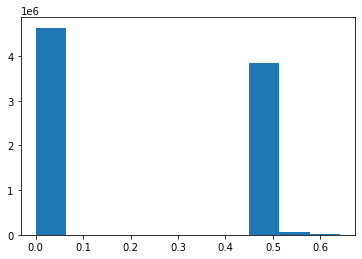

In [94]:
plt.ion()
plt.figure()
plt.hist(label_pred.flatten())
plt.show()

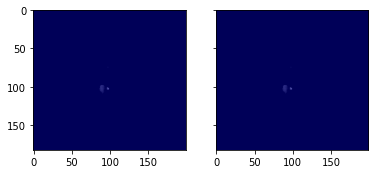

In [95]:
plt.ioff()
camera = video_comparison([brain, brain], 
                          [label_pred*(label_pred > 0.55), label], 
                          n_slides=128)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation